# 함수형 API

함수형 API: 함수 형태로 모델을 구축하는, 모델 구축 방법

- 층을 생성하고, 각 층의 입력과 출력 관계를 함수처럼 지정하고,
- 마지막에 Model() 에서 전체 모델의 입력층(inputs)과 출력층(outputs)의 인수를 설정해서 모델을 생성한다.
- 모델의 환경설정, 학습, 예측, 평가는 Sequential() 모델과 같이 model.compile(), model.fit(),model.predict(), model.evaluate()를 사용한다.
- 각 층을 생성하고, 생성된 층에 대해 input과 output이 함수처럼 지정 된 것을 볼 수 있다.

## Permute, Reshape, UpSampling1D, UpSampling2D

In [1]:
import tensorflow as tf
import numpy as np

#1:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
#2: create 2D input data
A = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8]], dtype='float32')
print(A)

[[1. 2. 3. 4.]
 [5. 6. 7. 8.]]


In [3]:
#2-1: np array reshape
A = A.reshape(1, 2, 4, 1)  # (batch, rows, cols, channels)
print(A)
shape = A.shape[1:]
print(shape)

[[[[1.]
   [2.]
   [3.]
   [4.]]

  [[5.]
   [6.]
   [7.]
   [8.]]]]
(2, 4, 1)


### Permute, Reshape

In [4]:
#3: build a model - Reshape, Permute
x = tf.keras.layers.Input(shape=A.shape[1:])
y = tf.keras.layers.Reshape([4, 2, 1])(x)  # 텐서의 형상 변경 (1, 4, 2, 1)
z = tf.keras.layers.Permute([2, 1, 3])(x)  # 텐서의 축 순서 변경

model = tf.keras.Model(inputs=x, outputs=[y, z])
model.summary()

#4: apply A to model
# output = model(A)
output = model.predict(A)

print('A[0,:,:,0]=', A[0:,:,0])
print('output[0]=', output[0][0,:,:,0])  # y
print('output[1]=', output[1][0,:,:,0])  # z

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 4, 1)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 4, 2, 1)      0           ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 4, 2, 1)      0           ['input_1[0][0]']                
                                                                                                  
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________
1/1 [=============================

### UpSampling1D, UpSampling2D

In [5]:
#3-2: build a model - UpSamkpling
x = tf.keras.layers.Input(shape=A.shape[1:])
y = tf.keras.layers.UpSampling2D()(x)  # size = (2, 2), [None, 4, 8, 1]
## row 방향으로 텐서 2배 확대, col 방향으로 텐서 2배 확대

u = tf.keras.layers.Reshape([8, 1])(x)
z = tf.keras.layers.UpSampling1D()(u)  # size = 2, [None, 16, 1]
## col 방향으로 텐서 2배 확대

model = tf.keras.Model(inputs=x, outputs=[y, z])
model.summary()

#4: apply A to model
# output = model(A)
output = model.predict(A)

print('A[0,:,:,0]=', A[0:,:,0])
print('output[0]=', output[0][0,:,:,0])  # y
print('output[1]=', output[1][0,:,0])    # z

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 4, 1)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 8, 1)         0           ['input_2[0][0]']                
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 4, 8, 1)      0           ['input_2[0][0]']                
                                                                                                  
 up_sampling1d (UpSampling1D)   (None, 16, 1)        0           ['reshape_1[0][0]']              
                                                                                            

## merge 연산

In [6]:
import tensorflow as tf
import numpy as np

#1:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

### 1D merge 연산

In [7]:
#2: 1D inut data: A, B
A = np.array([1, 2, 3, 4, 5]).astype('float32')
B = np.array([1, 2, 3, 4, 5, 6, 7, 8]).astype('float32')

# np.reshape(array, (batch, steps, channels))
## steps=-1, channels=정수 : 정수만큼의 col이 생기도록 자동 구조화
## steps=정수, channels=-1 : 정수만큼의 row가 
A = np.reshape(A, (1, -1, 1))  # A가 1개 col만 갖도록 변환
B = np.reshape(B, (1, -1, 1))  # B가 1개 col만 갖도록 변환

In [8]:
#3: build a model
input_x = tf.keras.layers.Input(shape=A.shape[1:])
input_y = tf.keras.layers.Input(shape=B.shape[1:])

# 최대풀링 저장
x = tf.keras.layers.MaxPool1D()(input_x)
y = tf.keras.layers.MaxPool1D()(input_y)

# 패딩 길이 차이를 저장
pad = y.shape[1] - x.shape[1]  # 2
# x모양을 y와 일치 시키기
x = tf.keras.layers.ZeroPadding1D(padding=(0, pad))(x)

out2 = tf.keras.layers.Add()([x, y])
# out2 = tf.keras.layers.Subtract()([x, y])
# out2 = tf.keras.layers.Multiply()([x, y])
# out2 = tf.keras.layers.Minimum()([x, y])
# out2 = tf.keras.layers.Maximum()([x, y])
# out2 = tf.keras.layers.Average()([x, y])
out3 = tf.keras.layers.Concatenate()([x, y])     # 분리된 맵 x, y를 연결
out4 = tf.keras.layers.Dot(axes=[1, 1])([x, y])  # inner product(내적) : 서로 같은 위치에 있는 원소의 곱을 더함
out5 = tf.keras.layers.Dot(axes=-1)([x, y])      # outer product(외적) : 원소의 곱을 모두 나열

out_list = [x, y, out2, out3, out4, out5]
model = tf.keras.Model(inputs=[input_x, input_y], outputs=out_list)
##model.summary()
print("model.output_shapes=", model.output_shape)

#4: apply [A, B] to model
##output = model([A, B])
output = model.predict([A, B])
for i in range(len(output)):
  print("output[{}]={}".format(i, output[i]))

model.output_shapes= [(None, 4, 1), (None, 4, 1), (None, 4, 1), (None, 4, 2), (None, 1, 1), (None, 4, 4)]
1/1 [==============================] - 0s 49ms/step
output[0]=[[[2.]
  [4.]
  [0.]
  [0.]]]
output[1]=[[[2.]
  [4.]
  [6.]
  [8.]]]
output[2]=[[[4.]
  [8.]
  [6.]
  [8.]]]
output[3]=[[[2. 2.]
  [4. 4.]
  [0. 6.]
  [0. 8.]]]
output[4]=[[[20.]]]
output[5]=[[[ 4.  8. 12. 16.]
  [ 8. 16. 24. 32.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


### 2D merge 연산

In [10]:
#2: 2D inut data: A, B
A = np.array([[1, 2],
            [3, 4]], dtype='float32')
A = np.reshape(A, (-1, 2, 2, 1))

B = np.array([[5, 6], 
            [7, 8]], dtype='float32')
B = np.reshape(B, (-1, 2, 2, 1))

C = np.array([1, 2, 3]).astype('float32')
C = C.reshape(-1, 3, 1, 1)

print('A=', A)
print('B=', B)
print('C=', C)

A= [[[[1.]
   [2.]]

  [[3.]
   [4.]]]]
B= [[[[5.]
   [6.]]

  [[7.]
   [8.]]]]
C= [[[[1.]]

  [[2.]]

  [[3.]]]]


In [11]:
#3: build a model
x = tf.keras.layers.Input(shape=A.shape[1:])
y = tf.keras.layers.Input(shape=B.shape[1:])
z = tf.keras.layers.Input(shape=C.shape[1:])

out2 = tf.keras.layers.Add()([x, y])
# out2 = tf.keras.layers.Subtract()([x, y])
# out2 = tf.keras.layers.Multiply()([x, y])
# out2 = tf.keras.layers.Minimum()([x, y])
# out2 = tf.keras.layers.Maximum()([x, y])
# out2 = tf.keras.layers.Average()([x, y])
out3 = tf.keras.layers.Concatenate()([x, y])
out4 = tf.keras.layers.Dot(axes=-1)([x, y])
out5 = tf.keras.layers.Dot(axes=-1)([x, y])

out_list = [x, y, z, out2, out3, out4, out5]
model = tf.keras.Model(inputs=[x, y, z], outputs=out_list)
##model.summary()
print("model.output_shapes=", model.output_shape)

#4: apply [A, B] to model
##output = model([A, B, C])
output = model.predict([A, B, C])
for i in range(len(output)):
  print("output[{}]={}".format(i, output[i]))

model.output_shapes= [(None, 2, 2, 1), (None, 2, 2, 1), (None, 3, 1, 1), (None, 2, 2, 1), (None, 2, 2, 2), (None, 2, 2, 2, 2), (None, 2, 2, 2, 2)]
1/1 [==============================] - 0s 98ms/step
output[0]=[[[[1.]
   [2.]]

  [[3.]
   [4.]]]]
output[1]=[[[[5.]
   [6.]]

  [[7.]
   [8.]]]]
output[2]=[[[[1.]]

  [[2.]]

  [[3.]]]]
output[3]=[[[[ 6.]
   [ 8.]]

  [[10.]
   [12.]]]]
output[4]=[[[[1. 5.]
   [2. 6.]]

  [[3. 7.]
   [4. 8.]]]]
output[5]=[[[[[ 5.  6.]
    [ 7.  8.]]

   [[10. 12.]
    [14. 16.]]]


  [[[15. 18.]
    [21. 24.]]

   [[20. 24.]
    [28. 32.]]]]]
output[6]=[[[[[ 5.  6.]
    [ 7.  8.]]

   [[10. 12.]
    [14. 16.]]]


  [[[15. 18.]
    [21. 24.]]

   [[20. 24.]
    [28. 32.]]]]]


## AND, OR, XOR 문제 해결하기

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

#1: ref [step37_01], [그림 2.9]
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

### AND, OR (1 Dense; 1개 퍼셉트론) 문제 해결하기

In [27]:
#2
X = np.array([[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]], dtype=np.float32)
y_and = np.array([[0], [0], [0], [1]], dtype=np.float32)
y_or = np.array([[0], [1], [1], [1]], dtype=np.float32)

In [28]:
#3: build a model
x_and = Input(shape = (2,))
out_and = Dense(units = 1, activation = 'sigmoid', name = 'and')(x_and)

x_or = Input(shape = (2,))
out_or = Dense(units = 1, activation = 'sigmoid', name = 'or')(x_or)

model = tf.keras.Model(inputs = [x_and, x_or], outputs = [out_and, out_or])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 and (Dense)                    (None, 1)            3           ['input_14[0][0]']               
                                                                                                  
 or (Dense)                     (None, 1)            3           ['input_15[0][0]']               
                                                                                            

In [29]:
#4: train and evaluate
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.1)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
ret = model.fit(x = [X, X], y = [y_and, y_or],
                epochs=100, batch_size=4, verbose=0)
test = model.evaluate(x = [X, X], y = [y_and, y_or], verbose = 0)
print('total loss =', test[0])
print('AND: loss={}, acc={}'.format(test[1], test[3]))
print('OR: loss={}, acc={}'.format(test[2], test[4]))

total loss = 0.006911134347319603
AND: loss=0.005227145738899708, acc=1.0
OR: loss=0.0016839883755892515, acc=1.0


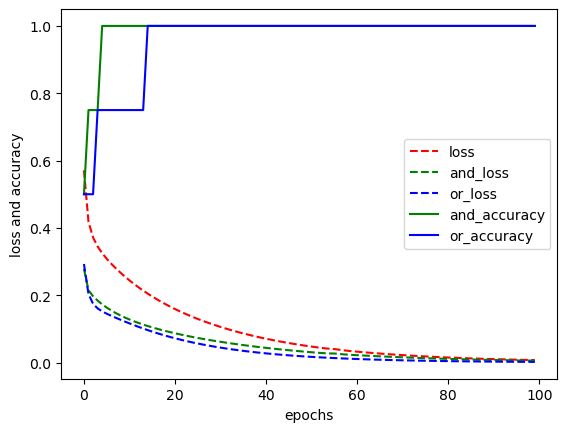

In [30]:
#5: draw graph
plt.plot(ret.history['loss'], 'r--', label='loss')
plt.plot(ret.history['and_loss'], 'g--', label='and_loss')
plt.plot(ret.history['or_loss'], 'b--', label='or_loss')
plt.plot(ret.history['and_accuracy'], 'g-', label='and_accuracy')
plt.plot(ret.history['or_accuracy'], 'b-', label='or_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(loc = 'best')
plt.show()

### AND, OR, XOR (2Dense: 다층 퍼셉트론 사용) 문제 해결하기

In [31]:
#2
X = np.array([[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]], dtype=np.float32)
y_and = np.array([[0], [0], [0], [1]], dtype=np.float32)
y_or = np.array([[0], [1], [1], [1]], dtype=np.float32)
y_xor = np.array([[0], [1], [1], [0]], dtype=np.float32)

y_and = tf.keras.utils.to_categorical(y_and)
y_or = tf.keras.utils.to_categorical(y_or)
y_xor = tf.keras.utils.to_categorical(y_xor)

In [32]:
#3: build a model
x_and = Input(shape = (2,))
x = Dense(units = 2, activation = 'sigmoid')(x_and)
out_and = Dense(units = 2, activation = 'softmax', name = 'and')(x)

x_or = Input(shape = (2,))
x = Dense(units = 2, activation = 'sigmoid')(x_or)
out_or = Dense(units = 2, activation = 'softmax', name = 'or')(x)

x_xor = Input(shape = (2,))
x = Dense(units = 2, activation = 'sigmoid')(x_xor)
out_xor = Dense(units = 2, activation = 'softmax', name = 'xor')(x)

model = tf.keras.Model(inputs = [x_and, x_or, x_xor], outputs = [out_and, out_or, out_xor])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 2)            6           ['input_16[0][0]']               
                                                                                            

In [33]:
#4: train and evaluate
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.1)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
ret = model.fit(x = [X, X, X], y = [y_and, y_or, y_xor],
                epochs=100, batch_size=4, verbose=0)
test = model.evaluate(x = [X, X, X], y = [y_and, y_or, y_xor], verbose = 0)
print('total loss =', test[0])
print('AND: loss={}, acc={}'.format(test[1], test[4]))
print('OR: loss={}, acc={}'.format(test[2], test[5]))
print('XOR: loss={}, acc={}'.format(test[3], test[6]))

total loss = 0.0006391436909325421
AND: loss=9.66314910328947e-05, acc=1.0
OR: loss=8.906275616027415e-05, acc=1.0
XOR: loss=0.0004534494364634156, acc=1.0


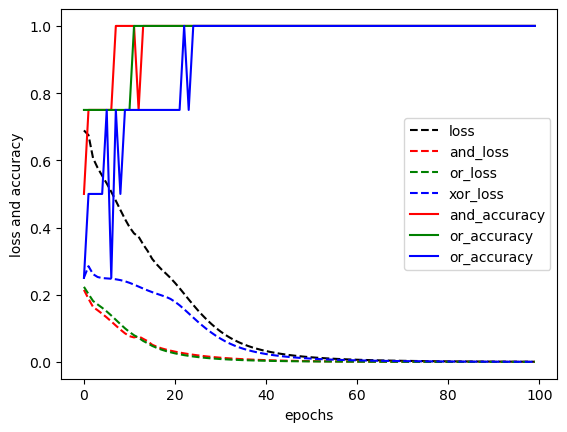

In [34]:
#5: draw graph
plt.plot(ret.history['loss'], 'k--', label='loss')
plt.plot(ret.history['and_loss'], 'r--', label='and_loss')
plt.plot(ret.history['or_loss'], 'g--', label='or_loss')
plt.plot(ret.history['xor_loss'], 'b--', label='xor_loss')

plt.plot(ret.history['and_accuracy'], 'r-', label='and_accuracy')
plt.plot(ret.history['or_accuracy'], 'g-', label='or_accuracy')
plt.plot(ret.history['xor_accuracy'], 'b-', label='or_accuracy')

plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(loc = 'best')
plt.show()